# Imports

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
from read_spin_configs import read_temp_dependent_files_then_merge
from sklearn.model_selection import train_test_split

# Loading and preprocessing the data

In [13]:
idir = r'C:\Users\Ebi\Desktop\ising2d\config-files\L=128'
L = 128
Tc = 2.2692
T_arr = np.round(np.arange(1.8, 3, 0.01), 4)
#T_arr = np.round(np.array([2.0, 2.4]), 4)
T_arr = np.append(T_arr, Tc)

In [14]:
X, y = read_temp_dependent_files_then_merge(
    idir, L, T_arr, Tc, max_configs_per_temperature=1000,)

In [16]:
print(X.shape, y.shape)

(121000, 128, 128, 1) (121000,)


In [17]:
N = X.shape[0]
L = X.shape[1] 

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

In [19]:
print('X.shape:', X.shape, ', y.shape:', y.shape)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

X.shape: (121000, 128, 128, 1) , y.shape: (121000,)
(96800, 128, 128, 1) (96800,)
(24200, 128, 128, 1) (24200,)


In [20]:
# number of classes (low temperature: 0, critical temperature: 1, high temperature: 2)
K = len(set(y_train))
print("number of classes:", K)

number of classes: 3


# Definition of the network and training for classification

In [21]:
# definition of the model
i = Input(shape=X_train[0].shape)

# Convolution block
x = Conv2D(32, (3,3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)

# Classification block
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(K, activation='softmax')(x)

model_phase = Model(i, x)

In [22]:
# Compiling the model

# Inverse time decaying learning rate
# initial_learning_rate / (1 + decay_rate * floor(step / decay_step))
initial_learning_rate = 0.01
decay_steps = 1.0
decay_rate = 0.5
learning_rate_fn = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate, decay_steps, decay_rate)

opt = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)

model_phase.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [23]:
# data augmentation, we allow for rotations of the image.
# At critical temperature, one could also allow for scalings?
batch_size = 20
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=90, horizontal_flip=True, vertical_flip=True)
train_generator = data_generator.flow(X_train, y_train, batch_size)
steps_per_epochs = X_train.shape[0] // batch_size

In [24]:
# training the model on the augmented dataset
r_phase = model_phase.fit(train_generator, validation_data=(X_test, y_test), steps_per_epoch=steps_per_epochs, epochs=50)

Epoch 1/50
4840/4840 [==============================] - 5449s 1s/step - loss: 1.6211 - accuracy: 0.9692 - val_loss: 0.0619 - val_accuracy: 0.9701
Epoch 2/50
4840/4840 [==============================] - 5341s 1s/step - loss: 0.0953 - accuracy: 0.9714 - val_loss: 0.0640 - val_accuracy: 0.9693
Epoch 3/50
4840/4840 [==============================] - 5339s 1s/step - loss: 0.0757 - accuracy: 0.9718 - val_loss: 0.0647 - val_accuracy: 0.9685
Epoch 4/50
4840/4840 [==============================] - 40200s 8s/step - loss: 0.0696 - accuracy: 0.9718 - val_loss: 0.0632 - val_accuracy: 0.9681
Epoch 5/50
4840/4840 [==============================] - 7023s 1s/step - loss: 0.0738 - accuracy: 0.9721 - val_loss: 0.0636 - val_accuracy: 0.9682
Epoch 6/50
4840/4840 [==============================] - 5339s 1s/step - loss: 0.0646 - accuracy: 0.9722 - val_loss: 0.0616 - val_accuracy: 0.9687
Epoch 7/50
4840/4840 [==============================] - 6112s 1s/step - loss: 0.0645 - accuracy: 0.9720 - val_loss: 0.0631 

KeyboardInterrupt: 

In [13]:
# We save the model
model_phase.save('cnn_ising_phase.h5')

In [63]:
# to load it:
model_phase = tf.keras.models.load_model('cnn_ising_phase.h5')

In [14]:
model_phase.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)       

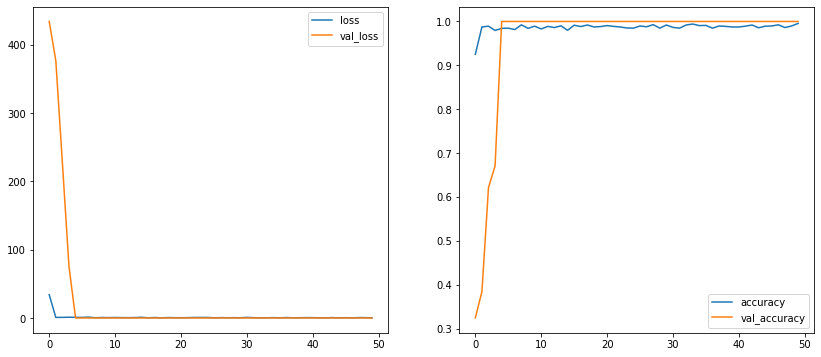

In [15]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(r_phase.history['loss'], label='loss')
plt.plot(r_phase.history['val_loss'], label='val_loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(r_phase.history['accuracy'], label='accuracy')
plt.plot(r_phase.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [16]:
# Let us plot the confusion matrix
p_test = model_phase.predict(X_test).argmax(axis=1)
conf_matrix = confusion_matrix(y_test, p_test)

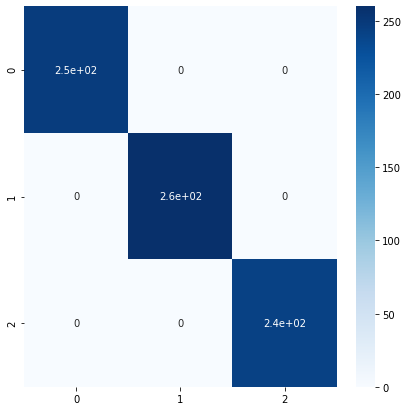

In [17]:
plt.figure(figsize=(7,7))
sns.heatmap(conf_matrix, cmap='Blues', annot=True)
plt.show()